# Deep dream

from [keras examples: deep_dream](https://github.com/fchollet/keras/blob/master/examples/deep_dream.py)

In [1]:
%matplotlib inline
from keras.preprocessing.image import load_img,img_to_array
import numpy as np 
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [2]:
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
import time
from keras.applications import vgg16
from keras.layers import Input

In [3]:
## dim of generated image size
img_width = 600
img_height = 600

In [4]:
# path to the model weights file
weights_path = 'vgg16_weight.h5'
# some settings we found interesting
saved_settings = {
    'bad_trip': {'features': {'block4_conv1': 0.05,
                              'block4_conv2': 0.01,
                              'block4_conv3': 0.01},
                 'continuity': 0.1,
                 'dream_l2': 0.8,
                 'jitter': 5},
    'dreamy': {'features': {'block5_conv1': 0.05,
                            'block5_conv2': 0.02},
               'continuity': 0.1,
               'dream_l2': 0.02,
               'jitter': 0},
}
# the settings we will use in this experiment
settings = saved_settings['dreamy']
result_prefix = 'my_test'

In [5]:
settings

{'continuity': 0.1,
 'dream_l2': 0.02,
 'features': {'block5_conv1': 0.05, 'block5_conv2': 0.02},
 'jitter': 0}

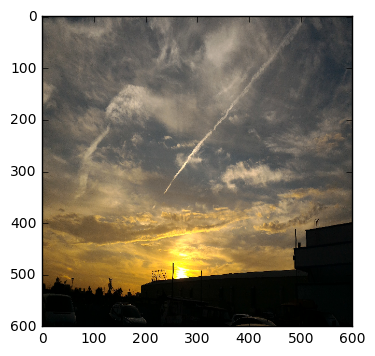

In [6]:
image_path = './sky_scence.jpg'
img = load_img(image_path,target_size=(img_width,img_height))
# img = img_to_array(img)
plt.imshow(img)

img shape: (600, 600, 3)


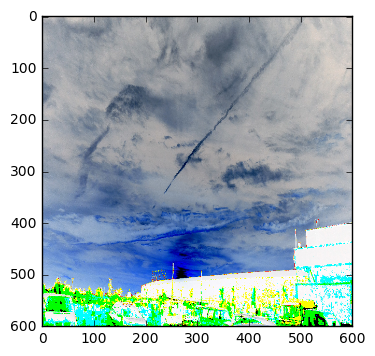

In [7]:
img = img_to_array(img)
print 'img shape:',img.shape
plt.imshow(img)

In [8]:
img = np.expand_dims(img,axis=0)
print img.shape

(1, 600, 600, 3)


In [9]:
def preprocess_image(image_path):
    img = load_img(image_path,target_size=(img_width,img_height))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [10]:
x = preprocess_image(image_path)

In [33]:
def deprocess_image(x):
    # backend == 'tf'
    if K.image_dim_ordering =='th':
        x = x.reshpae((3,img_width,img_height))
    else:
        x = x.reshape((img_width,img_height,3))
    # remove zero-center by mean pixel
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    # BGR->RGB
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

In [12]:
if K.image_dim_ordering() == 'th':
    img_size = (3, img_width, img_height)
else:
    img_size = (img_width, img_height, 3)

In [13]:
# this will contain our generated image
dream = Input(batch_shape=(1,) + img_size)
dream

<tf.Tensor 'input_1:0' shape=(1, 600, 600, 3) dtype=float32>

In [14]:
# build VGG16 network with placeholder
# model will be loaded with pre-trained weight

model = vgg16.VGG16(input_tensor=dream,
                   weights='imagenet',include_top=False)
print 'model loaded!!'

model loaded!!


In [15]:
layer_dict = dict([(layer.name,layer) for layer in model.layers])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Convolution2D at 0x7fc691900e10>,
 'block1_conv2': <keras.layers.convolutional.Convolution2D at 0x7fc691969110>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7fc69199c450>,
 'block2_conv1': <keras.layers.convolutional.Convolution2D at 0x7fc691974b50>,
 'block2_conv2': <keras.layers.convolutional.Convolution2D at 0x7fc68bbdfb50>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7fc690031490>,
 'block3_conv1': <keras.layers.convolutional.Convolution2D at 0x7fc69003b290>,
 'block3_conv2': <keras.layers.convolutional.Convolution2D at 0x7fc68bb96f50>,
 'block3_conv3': <keras.layers.convolutional.Convolution2D at 0x7fc69192a590>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7fc690079b90>,
 'block4_conv1': <keras.layers.convolutional.Convolution2D at 0x7fc690087e10>,
 'block4_conv2': <keras.layers.convolutional.Convolution2D at 0x7fc6900a1790>,
 'block4_conv3': <keras.layers.convolutional.Convolution2D at 0x7fc68834c710

In [16]:
# continuity loss util function
def continuity_loss(x):
    assert K.ndim(x) == 4
    if K.image_dim_ordering() == 'th':
        a = K.square(x[:, :, :img_width - 1, :img_height - 1] -
                     x[:, :, 1:, :img_height - 1])
        b = K.square(x[:, :, :img_width - 1, :img_height - 1] -
                     x[:, :, :img_width - 1, 1:])
    else:
        a = K.square(x[:, :img_width - 1, :img_height-1, :] -
                     x[:, 1:, :img_height - 1, :])
        b = K.square(x[:, :img_width - 1, :img_height-1, :] -
                     x[:, :img_width - 1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

In [17]:
layer_dict[settings['features'].keys()[0]].output

<tf.Tensor 'Relu_11:0' shape=(1, 37, 37, 512) dtype=float32>

In [18]:
loss = K.variable(0.)
for layer_name in settings['features']:
    # add the L2 norm of the features of a layer to the loss
    assert layer_name in layer_dict.keys() , 'Layer' + layer_name + 'not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    shape = layer_dict[layer_name].output_shape
    
    # we avoid border artifacts by only involving non-border pixels in the loss
    if K.image_dim_ordering() == 'th':
        loss -= coeff * K.sum(K.square(x[:, :, 2: shape[2] - 2, 2: shape[3] - 2])) / np.prod(shape[1:])
    else:
        loss -= coeff * K.sum(K.square(x[:, 2: shape[1] - 2, 2: shape[2] - 2, :])) / np.prod(shape[1:])

In [19]:
# add continuity loss (gives image local coherence, can result in an artful blur)
loss += settings['continuity'] * continuity_loss(dream) / np.prod(img_size)
# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
loss += settings['dream_l2'] * K.sum(K.square(dream)) / np.prod(img_size)

In [20]:
# compute the gradients of the dream wrt the loss
grads = K.gradients(loss,dream)

In [21]:
outputs = [loss]
if type(grads) in {list,tuple}:
    outputs += grads
else:
    outputs.append(grads)


In [22]:
f_outputs = K.function([dream],outputs)

In [23]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [24]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


In [25]:
evaluator = Evaluator()

In [35]:
x = preprocess_image(image_path)


In [36]:
for i in range(5):
    print('Start of iteration', i)
    start_time = time.time()

    # add a random jitter to the initial image. This will be reverted at decoding time
    random_jitter = (settings['jitter'] * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter

    # run L-BFGS for 7 steps
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    # decode the dream and save it
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess_image(np.copy(x))
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', -21.440872)
('Image saved as', 'my_test_at_iteration_0.png')
('Start of iteration', 1)
('Current loss value:', -287.66159)
('Image saved as', 'my_test_at_iteration_1.png')
('Start of iteration', 2)
('Current loss value:', -991.62805)
('Image saved as', 'my_test_at_iteration_2.png')
('Start of iteration', 3)
('Current loss value:', -3208.7114)
('Image saved as', 'my_test_at_iteration_3.png')
('Start of iteration', 4)
('Current loss value:', -6439.3105)
('Image saved as', 'my_test_at_iteration_4.png')
Iteration 4 completed in 117s


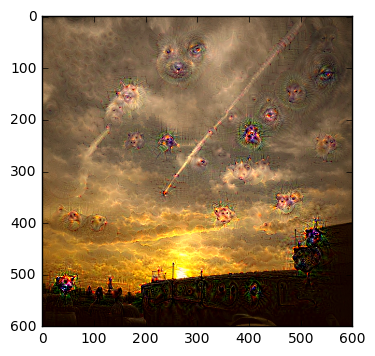

In [41]:
plt.imshow(load_img('./my_test_at_iteration_4.png'))